In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 下载NLTK数据
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/leo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

类别分布:
ham     4825
spam     747
Name: label, dtype: int64


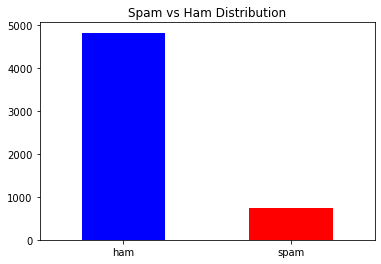

In [2]:
# 加载数据集
url = "https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv"
data = pd.read_csv(url, encoding='latin-1')
data = data[['v1', 'v2']]  # 只保留标签和文本列
data.columns = ['label', 'text']  # 重命名列

# 查看数据
print(data.head())
print("\n类别分布:")
print(data['label'].value_counts())

# 可视化类别分布
data['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title("Spam vs Ham Distribution")
plt.xticks(rotation=0)
plt.show()

In [3]:
# 初始化stemmer和stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 移除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 转换为小写
    text = text.lower()
    
    # 分词
    words = text.split()
    
    # 移除停用词并词干提取
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# 应用预处理
data['processed_text'] = data['text'].apply(preprocess_text)

# 查看预处理后的文本
print("\n预处理后的文本示例:")
print(data[['text', 'processed_text']].head())


预处理后的文本示例:
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      processed_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4          nah dont think goe usf live around though  


In [4]:
# 将标签转换为数值 (spam:1, ham:0)
data['label_num'] = data['label'].map({'ham': 0, 'spam': 1})

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    data['processed_text'], data['label_num'], test_size=0.3, random_state=42
)

# 使用词袋模型提取特征
vectorizer = CountVectorizer(max_features=5000)  # 限制特征数量
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 查看特征矩阵
print("\n特征矩阵形状:", X_train_vec.shape)
print("示例特征:")
print(vectorizer.get_feature_names_out()[:20])  # 查看前20个特征词



特征矩阵形状: (3900, 5000)
示例特征:
['008704050406' '0089mi' '0121' '0125698789' '02' '020603' '0207'
 '02070836089' '02072069400' '02073162414' '020903' '050703' '0578'
 '061104' '07046744435' '07090201529' '07090298926' '07099833605' '071104'
 '07123456789']



模型准确率: 0.9827

分类报告:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1453
           1       0.96      0.90      0.93       219

    accuracy                           0.98      1672
   macro avg       0.97      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672


混淆矩阵:
[[1445    8]
 [  21  198]]


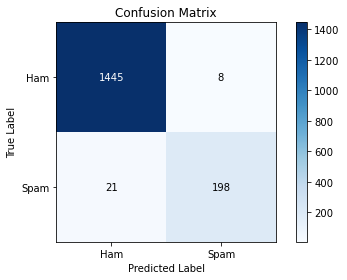

In [5]:
# 初始化并训练多项式朴素贝叶斯模型
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# 预测
y_pred = nb_classifier.predict(X_test_vec)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
print(f"\n模型准确率: {accuracy:.4f}")

# 分类报告
print("\n分类报告:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(conf_matrix)

# 可视化混淆矩阵
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Ham', 'Spam'])
plt.yticks(tick_marks, ['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

plt.tight_layout()
plt.show()

In [6]:
# 创建一个完整的管道（预处理+特征提取+分类）
pipeline = make_pipeline(
    CountVectorizer(preprocessor=preprocess_text, max_features=5000),
    MultinomialNB()
)

# 使用原始文本数据重新划分数据集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    data['text'], data['label_num'], test_size=0.3, random_state=42
)

# 训练管道
pipeline.fit(X_train_raw, y_train)

# 评估
y_pred_pipe = pipeline.predict(X_test_raw)
print("\n管道模型准确率:", accuracy_score(y_test, y_pred_pipe))



管道模型准确率: 0.9826555023923444


In [7]:
# 定义测试函数
def test_email(email_text):
    proba = pipeline.predict_proba([email_text])[0]
    prediction = pipeline.predict([email_text])[0]
    
    print(f"\n邮件内容: {email_text}")
    print(f"预测结果: {'垃圾邮件' if prediction == 1 else '正常邮件'}")
    print(f"概率 - 正常邮件: {proba[0]:.4f}, 垃圾邮件: {proba[1]:.4f}")

# 测试一些示例
test_email("Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now!")
test_email("Hi John, just checking in to see if you're still on for lunch tomorrow at 12?")
test_email("URGENT! Your bank account has been compromised. Click this link to secure your account now!")
test_email("Meeting reminder: Project review at 3pm in conference room B. Please bring your reports.")


邮件内容: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now!
预测结果: 垃圾邮件
概率 - 正常邮件: 0.0000, 垃圾邮件: 1.0000

邮件内容: Hi John, just checking in to see if you're still on for lunch tomorrow at 12?
预测结果: 正常邮件
概率 - 正常邮件: 1.0000, 垃圾邮件: 0.0000

邮件内容: URGENT! Your bank account has been compromised. Click this link to secure your account now!
预测结果: 垃圾邮件
概率 - 正常邮件: 0.0027, 垃圾邮件: 0.9973

邮件内容: Meeting reminder: Project review at 3pm in conference room B. Please bring your reports.
预测结果: 正常邮件
概率 - 正常邮件: 0.9995, 垃圾邮件: 0.0005



最具指示性的垃圾邮件词汇:
          word  log_prob
1255     claim  5.279541
3054     prize  5.056398
4272      tone  4.879941
2005  guarante  4.447808
381        500  4.333397
178        150  4.238087
214         18  4.204186
131        100  4.169094
198     150ppm  4.055766
3322   rington  4.055766
1758     entri  4.014944
700      award  4.014944
2958      poli  3.972384
4463    urgent  3.927932
4655    weekli  3.832622
411       8007  3.781329
270        250  3.781329
382       5000  3.727262
184       150p  3.727262
132       1000  3.699091


<Figure size 720x432 with 0 Axes>

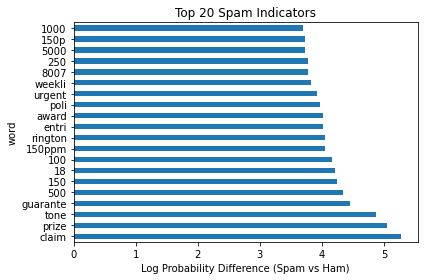

In [8]:
# 获取特征重要性
feature_names = pipeline.named_steps['countvectorizer'].get_feature_names_out()
coefs = pipeline.named_steps['multinomialnb'].feature_log_prob_

# 创建DataFrame显示最重要的垃圾邮件词汇
spam_words = pd.DataFrame({
    'word': feature_names,
    'log_prob': coefs[1] - coefs[0]  # 垃圾邮件相对于正常邮件的对数概率差异
}).sort_values('log_prob', ascending=False)

print("\n最具指示性的垃圾邮件词汇:")
print(spam_words.head(20))

# 可视化top垃圾邮件词汇
plt.figure(figsize=(10, 6))
spam_words.head(20).plot.barh(x='word', y='log_prob', legend=False)
plt.title('Top 20 Spam Indicators')
plt.xlabel('Log Probability Difference (Spam vs Ham)')
plt.tight_layout()
plt.show()